# Week 8 Assignment
Code a genetic algorithm to optimize a particular problem. My problem of choice is the traveling salesman problem - visit all cities in a list in the shortest distance possible without revisiting already visited cities.

In [ ]:
############
# Built-In #
############
import copy
from math import factorial
from random import shuffle, sample, random

###############
# Third-Party #
###############
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

## Data Loading

In [ ]:
drive.mount('/data/', force_remount = True)
data_dir = '/data/My Drive/EMSE 6574/data'
data = pd.read_csv(f'{data_dir}/cities_distance.csv')
data = data.rename(columns = {'Unnamed: 0': 'Cities'})
data = data.set_index('Cities')
data.head()

Mounted at /data/


,Anchorage,Atlanta,Austin,Baltimore,Boston,Chicago,Dallas,Denver,Honolulu,Houston,Indianapolis,Jacksonville,Las Vegas,Los Angeles,Memphis,Miami,New Orleans,New York,Newark,Oakland,Philadelphia,Phoenix,Portland,San Antonio,San Diego,San Francisco,San Jose,Seattle,Tampa,Tucson,Washington DC
Cities,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anchorage,0.00,5471.52,5091.57,5392.82,5416.45,4584.33,4904.83,3851.73,4477.41,5260.73,4842.61,5930.14,3690.71,3763.14,5043.17,6432.89,5518.05,5405.80,5395.22,3226.82,5411.40,4092.45,2475.54,5133.22,3941.20,3223.75,3287.92,2307.09,6108.57,4263.73,5405.01
Atlanta,5471.52,0.00,1315.28,927.35,1505.11,944.40,1157.42,1945.42,7224.89,1126.72,687.11,458.63,2801.21,3108.01,541.43,973.84,682.33,1199.53,1189.80,3421.08,1070.25,2554.73,3487.64,1417.45,3034.87,3434.28,3392.03,3503.07,670.37,2472.45,871.28
Austin,5091.57,1315.28,0.00,2166.00,2724.01,1571.76,293.52,1240.77,6029.37,235.70,1489.43,1542.05,1741.71,1970.09,900.47,1790.08,737.71,2429.87,2417.66,2399.98,2308.05,1396.55,2746.72,118.35,1856.72,2411.91,2356.30,2845.71,1504.82,1270.22,2116.17
Baltimore,5392.82,927.35,2166.00,0.00,577.85,973.23,1947.28,2422.32,7792.75,2010.47,819.41,1096.09,3377.44,3722.45,1273.23,1538.50,1606.55,272.44,262.47,3928.61,144.13,3216.98,3788.62,2278.29,3685.28,3941.99,3912.27,3744.10,1370.72,3171.66,57.16
Boston,5416.45,1505.11,2724.01,577.85,0.00,1366.63,2490.97,2838.62,8171.81,2578.59,1295.31,1635.65,3809.81,4166.43,1824.47,2022.46,2184.18,305.61,315.41,4317.11,435.06,3690.84,4073.04,2838.36,4146.55,4330.34,4307.42,3997.08,1902.93,3662.03,633.85


## Genetic Algorithm

In [ ]:
class TravelingSalesmanGeneticAlgorithm():
    '''Optimize the "Traveling Salesman" problem with a genetic algorithm.

    This class will randomly initialize a starting state based on the input
    parameters. Running the `optimize` method will then go through the
    genetic algorithm process to optimize the path.

    Attributes
    ----------
    starting_city : str
        The name of the city to start traveling from.

    cities_list : list[str]
        List of city names to visit and pull distances
        from using the distance matrix.

    distance_matrix : pandas DataFrame
        Distance matrix representation in DataFrame format.
        The indices should be set to the city names and the
        column names should also be the city names. When doing
        a `loc[city_1, city_2]` call on the distance matrix,
        it should return the distance from city_1 to city_2.

    population_size : int, default=10
        The size of the population to generate for the starting state.

    num_iter : int, default=50
        Number of iterations to run optimization.

    keep_top_n : int or float, default=0.5
        If an integer, the number of top city paths to keep each
        generation. If a float, the percentage of top city paths
        to keep each generation.

    mutation_rate : float, default=0.5
        Probability of introducting a mutation in each
        offspring city sequence.

    _iteration_progress : list[float]
        Internal list of best distances achieved over
        each iteration for use in graphing at the end.
    '''
    def __init__(
        self, 
        starting_city,
        cities_list,
        distance_matrix, 
        population_size=10, 
        num_iter=50, 
        keep_top_n=0.5,
        mutation_rate=0.5
    ):
        self.starting_city = starting_city
        self.cities_list = cities_list
        self.distance_matrix = distance_matrix
        self.population_size = population_size
        self.num_iter = num_iter
        self.keep_top_n = keep_top_n
        self.mutation_rate = mutation_rate
        self._iteration_progress = []

        # Create initial starting population
        self.starting_states = self._generate_start_state()

    def _generate_start_state(self):
        '''Generate a random starting state.
        
        This function will generate a random starting population
        of city sequences for the genetic algorithm to build off of.
        '''
        final_population = []
        max_combos = factorial(len(self.cities_list) - 1)

        for _ in range(self.population_size):
            temp_cities_list = copy.deepcopy(self.cities_list)

            # Remove the starting city from the cities list (in-place)
            # so random ordering does not include starting city
            temp_cities_list.remove(self.starting_city)

            # Randomly order remaining list of cities (in-place)
            shuffle(temp_cities_list)

            # Add in starting city at beginning and end
            potential_cities_list = (
                [self.starting_city] + temp_cities_list + [self.starting_city]
            )

            # Need to make sure we don't add in duplicate city sequences, but
            # we also don't want to be stuck in a loop if there are no more
            # possible unique combinations so we break out if we've gotten
            # all the possible combinations even if we haven't reached
            # the population size yet.
            while potential_cities_list in final_population:
                if len(final_population) < max_combos:
                    shuffle(temp_cities_list)
                    potential_cities_list = (
                        [self.starting_city] + temp_cities_list + [self.starting_city]
                    )
                else:
                    break
            else:
                final_population.append(potential_cities_list)

        return final_population

    def _evaluate(self, city_list):
        '''Helper function to evaluate distances.'''
        total_distance = 0

        for i in range(len(city_list) - 1):
            curr_city = city_list[i]
            next_city = city_list[i + 1]
            total_distance += self.distance_matrix.loc[curr_city, next_city]

        return total_distance

    def evaluate(self, population):
        '''Calculate the total distances for each city sequence.
        
        Parameters
        ----------
        population : list[list[str]]
            List of city sequences to calculate distances.
        '''
        eval_results = []
        for member in population:
            eval_results.append(self._evaluate(member))

        return eval_results

    def reduce_population(self, population, eval_results):
        '''Reduce the population to the top results to generate offspring.
        
        Parameters
        ----------
        population : list[list[str]]
            List of city sequences (lists of strings).

        eval_results : list[float]
            List of calculated total distances for each city sequence.
        '''
        # Sort the results and get the indices
        # in order to get the right population rows
        sorted_indices = np.argsort(eval_results)

        # Determine how many top population members
        # to keep based on if `keep_top_n` is a float
        # or an integer
        if isinstance(self.keep_top_n, float):
            top_n = max(int(self.keep_top_n * len(eval_results)), 1)
        else:
            top_n = keep_top_n
        final_indices = sorted_indices[:top_n]

        # Pull the appropriate population rows
        reduced_population = np.array(population)[final_indices].tolist()

        return reduced_population

    def _crossover(self, reduced_population):
        '''Helper function to do the crossover operation on a sequence.

        This function implements the "partially mapped crossover" operation
        as discussed in https://www.hindawi.com/journals/cin/2017/7430125/#B25.

        Parameters
        ----------
        reduced_population : list[list[str]]
            List of reduced city sequences.
        '''
        parents = sample(reduced_population, 2)
    
        for i, parent in enumerate(parents):
            parent_path = np.array(parent[1:-1])
            parent_splits = np.array_split(parent_path, 3)  

            if i == 0:
                parent_1_splits = parent_splits
            else:
                parent_2_splits = parent_splits

        # Creating mapping of middle splits from parents
        mapping_dict = {}
        parent_1_mid = parent_1_splits[1]
        parent_2_mid = parent_2_splits[1]

        for i in range(len(parent_1_mid)):
            mapping_dict.setdefault(parent_1_mid[i], []).append(parent_2_mid[i])
            mapping_dict.setdefault(parent_2_mid[i], []).append(parent_1_mid[i])

        # Swap middle splits of parents to start with each offspring
        offspring_1_mid = parent_2_splits[1].tolist()
        offspring_2_mid = parent_1_splits[1].tolist()

        parent_1_beg = parent_1_splits[0]
        parent_1_end = parent_1_splits[2]
        parent_2_beg = parent_2_splits[0]
        parent_2_end = parent_2_splits[2]
        offspring_list = [[], []]
        for i, offspring in enumerate(offspring_list):
            parent_beginning = parent_1_beg if i == 0 else parent_2_beg
            parent_ending = parent_1_end if i == 0 else parent_2_end
            offspring_middle = offspring_1_mid if i == 0 else offspring_2_mid
            
            # For offspring, fill in parts from parent 1 or 2
            # while replacing any already present values with a value
            # from the mapping dictionary. We want to iterate through
            # each index in each parent part as opposed to just copying 
            # the whole list to ensure there are no duplicate cities 
            # in the final list.
            for j, parent_part in enumerate([parent_beginning, parent_ending]):
                offspring_part = offspring_middle if j == 0 else offspring_list[i]
                for k in range(len(parent_part)):
                    city = parent_part[k]
                    if city not in offspring_part:
                        offspring_list[i].append(city)
                    else:
                        # Since there can multiple mappings to one city, 
                        # we need to iterate through the list and break
                        # out when we find a city that is not in the offspring
                        new_city_added = False
                        visited_cities = []
                        potential_cities = mapping_dict[city]

                        while not new_city_added:
                            for potential_city in potential_cities:
                                if potential_city not in offspring_part:
                                    offspring_list[i].append(potential_city)
                                    new_city_added = True
                                    break
                                else:
                                    visited_cities.append(potential_city)
                            else:
                                potential_cities = mapping_dict[visited_cities.pop()]
                if j == 0:
                    offspring_list[i].extend(offspring_part)

            offspring_list[i] = [self.starting_city] + offspring_list[i] + [self.starting_city]

        return offspring_list

    def _mutate(self, offspring_list):
        '''Helper function to mutate a city sequence.

        This will only mutate a particular offspring at a certain probability
        which is set as `mutation_rate`.

        Parameters
        ----------
        offspring_list : list[list[str]]
            List of offspring city sequences.
        '''
        for offspring in offspring_list:
            if random() < self.mutation_rate:
                indices = sample(range(1, len(offspring) - 1), 2)
                city_1 = offspring[indices[0]]
                city_2 = offspring[indices[1]]
                offspring[indices[0]] = city_2
                offspring[indices[1]] = city_1

        return offspring_list

    def procreate(self, reduced_population):
        '''Generate offspring with two parents drawn from the inputs.

        The parents are randomly selected from the `reduced_population` list
        to generate offspring. A random mutation is also introduced at a
        probability of `mutation_rate`.

        Parameters
        ----------
        reduced_population : list[list[str]]
            List of reduced city sequences.
        '''
        reduced_pop_size = len(reduced_population)
        new_population = []

        while len(new_population) < self.population_size - reduced_pop_size:
            new_population.extend(self._crossover(reduced_population))

        new_population = self._mutate(new_population)
        new_population.extend(reduced_population)

        return new_population

    def optimize(self, verbose=False): 
        '''Run the optimization algorithm.

        Parameters
        ----------
        verbose : bool, default=False
            If `True`, will print out some more information
            about each iteration.
        '''
        best_distance = 1E10
        best_sequence = []

        # Optimize using genetic algorithm
        for i in range(self.num_iter):
            if verbose:
                print(f'OPTIMIZING ROUND {i + 1}/{self.num_iter}'.center(100, '='))
            
            # We want to make sure to keep population size the same
            # so we only pull the last `population_size` rows.
            if verbose: 
                print('Procreating...')
            starting_idx = -self.population_size
            population = (
                self.starting_states if i == 0 
                else self.procreate(reduced_population)[starting_idx:]
            )
    
            # Evaluate sequences
            if verbose:
                print('Evaluating...')
            eval_results = self.evaluate(population)

            # Sort the results and get best resulting index
            best_idx = np.argsort(eval_results)[0]

            # Get best distance and sequence
            iter_best = eval_results[best_idx]
            is_better = iter_best < best_distance
            best_distance = iter_best if is_better else best_distance
            best_sequence = self.starting_states[best_idx] if is_better else best_sequence

            # Reduce the population to best
            if verbose:
                print('Selecting best...')
            reduced_population = self.reduce_population(population, eval_results)
    
            # Add iteration results to internal results tracker
            self._iteration_progress.append(best_distance)

            if verbose:
                # Print best result of this iteration
                print(f'Best Distance Achieved: {best_distance} - {best_sequence}')
                print('=' * 100)

        print(f'Best Overall: {best_distance} - {best_sequence}')

        # Generate graph of optimization progress.
        fig, ax = plt.subplots()
        sns.lineplot(
            x = range(1, len(self._iteration_progress) + 1),
            y = self._iteration_progress,
            ax = ax
        );
        ax.set_title('Distance vs. Iteration Number');


=======================================OPTIMIZING ROUND 1/100=======================================
Procreating...
Evaluating...
Selecting best...
Best Distance Achieved: 25987.34 - ['Chicago', 'Indianapolis', 'Anchorage', 'Honolulu', 'Boston', 'Austin', 'Houston', 'Dallas', 'Denver', 'Atlanta', 'Baltimore', 'Chicago']
=======================================OPTIMIZING ROUND 2/100=======================================
Procreating...
Evaluating...
Selecting best...
Best Distance Achieved: 25987.34 - ['Chicago', 'Indianapolis', 'Anchorage', 'Honolulu', 'Boston', 'Austin', 'Houston', 'Dallas', 'Denver', 'Atlanta', 'Baltimore', 'Chicago']
=======================================OPTIMIZING ROUND 3/100=======================================
Procreating...
Evaluating...
Selecting best...
Best Distance Achieved: 25987.34 - ['Chicago', 'Indianapolis', 'Anchorage', 'Honolulu', 'Boston', 'Austin', 'Houston', 'Dallas', 'Denver', 'Atlanta', 'Baltimore', 'Chicago']
==================================

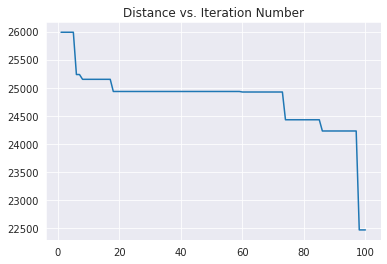

In [ ]:
tsp_ga = TravelingSalesmanGeneticAlgorithm(
    starting_city = 'Chicago', 
    cities_list = data.columns[:11].tolist(), 
    distance_matrix = data,
    population_size = 10,
    num_iter = 100,
    keep_top_n = 0.5,
    mutation_rate = 0.1
)
tsp_ga.optimize(verbose = True)